## Import packages

In [1]:
#import the models and plotting tools

import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PseudoVoigtModel  ##error: No module named 'lmfit'
from lmfit import Model
from lmfit.parameter import Parameters
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
from scipy.signal import medfilt
import glob, os

import time
import os
import pickle

#import diamond_functions as dia
from diamond_functions import *

#for graphs inline with the text on mac and widows...
%matplotlib inline
#for interactive graphs inline with the text on mac and widows...
#%matplotlib interactive
#best for pop-out graphs on windows...
#%matplotlib tk
#best for pop-out graphs on mac...
# %matplotlib
#for pop-out graphs on mac and windows, but it's a bit dodgey...
#%matplotlib qt

## Adjusting plot parameters

In [2]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Define directory & fileprefix:

In [3]:
base_dir= r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy'
pickles_dir = base_dir + '\Looped Fit Results'
out_dir = base_dir + '\Looped Fit Results\Plots'
pickle_ftype = '\*.pickle'

print('Pickle files directory = ' + pickles_dir)
print('Output folder is: ' + out_dir)

Pickle files directory = C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Looped Fit Results
Output folder is: C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Looped Fit Results\Plots


## Load a data file

Enter which peak file you wish to analyse:

Text(0.5, 1.0, 'Sample 2')

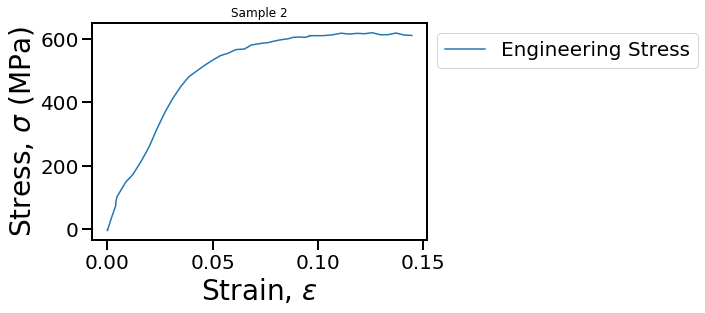

In [4]:
## Load mechanical data from file
Eng_stress = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=0)
Eng_stress = Eng_stress[:-1]
Eng_strain = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=1)
Eng_strain = Eng_strain[:-1]
plt.plot(Eng_strain, Eng_stress, label = 'Engineering Stress')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=28)
plt.xlabel('Strain, ${\epsilon}$', fontsize=28)
plt.title('Sample 2')

In [5]:
## Load in all intensity files and chack how many exist ##update location required
dicts = glob.glob(pickles_dir + pickle_ftype)
num_dicts=len(dicts)
dics_list = list(dicts)


print('Number of files in dir = ', num_dicts)
dic_names = []
for i in dics_list:
    x = (i.split('\\')[-1])
    dic_names.append(x)
print('Length of names list: ', len(dic_names))
for i in dic_names:
    print(i)

Number of files in dir =  108
Length of names list:  108
Cake_0_(01-10) & (111).pickle
Cake_0_(220) & (11-20).pickle
Cake_0_(311) & (02-20).pickle
Cake_10_(01-10) & (111).pickle
Cake_10_(01-13) & (311) & (02-20).pickle
Cake_10_(220) & (11-20).pickle
Cake_11_(01-10) & (111).pickle
Cake_11_(01-13) & (311) & (02-20).pickle
Cake_11_(220) & (11-20).pickle
Cake_12_(01-10) & (111).pickle
Cake_12_(01-13) & (311) & (02-20).pickle
Cake_12_(220) & (11-20).pickle
Cake_13_(01-10) & (111).pickle
Cake_13_(01-13) & (311) & (02-20).pickle
Cake_13_(220) & (11-20).pickle
Cake_14_(01-10) & (111).pickle
Cake_14_(01-13) & (311) & (02-20).pickle
Cake_14_(220) & (11-20).pickle
Cake_15_(01-10) & (111).pickle
Cake_15_(01-13) & (311) & (02-20).pickle
Cake_15_(220) & (11-20).pickle
Cake_16_(01-10) & (111).pickle
Cake_16_(220) & (11-20).pickle
Cake_16_(311) & (02-20).pickle
Cake_17_(01-10) & (111).pickle
Cake_17_(220) & (11-20).pickle
Cake_17_(311) & (02-20).pickle
Cake_18_(01-10) & (111).pickle
Cake_18_(220) & (1

In [6]:
list_matrix_peaks = []
list_matrix_peak_centers = []
list_matrix_peak_fwhm = []
list_matrix_peak_amplitude = []

list_ZrH_peaks = []
list_ZrH_peak_centres = []
list_ZrH_peak_fwhm = []
list_ZrH_peak_amplitude = []

In [7]:
for pickles in dic_names:
    with open(pickles_dir + '\\' + pickles, 'rb') as x:
        data = pickle.load(x)
    #print(len(data))
    #enter names of reflections in dictionary you intend to analyse
    reflections=pickles[pickles.find('('):-7]
    cake = pickles.split('_')[1]
        
    # Seperate reflections from a filename
    def find(ch,string1):
        pos = []
        for i in range(len(string1)):
            if ch == string1[i]:
                pos.append(i)
        return(pos)

    allpeaks = []
    for i,j in zip(find('(', pickles), find(')', pickles)):
        allpeaks.append(pickles[i:j+1])
        
    numpeaks=len(allpeaks)
    print("Reflections: {: >25}      Cake = {: >3}       Peaks in Pickle = {: >3}      Peaks List: {}".format(reflections, cake, numpeaks, allpeaks))

### Extracting peak centres

    firstFile = 0
    lastFile = len(data)
    #print('Number of Strain Steps: {0}'.format(lastFile))
    step = 1

### isolate hydride reflections
    
    #n = number of reflections in peak_list, peak will be the reflections in the peak_list
    for n, peak in enumerate(allpeaks):
        
        #set up dictionaries to store the peak information
        m_peak_centres={}
        m_peak_fwhm={}
        m_peak_amplitude={}    
        ZrH_peak_centres={}
        ZrH_peak_fwhm={}
        ZrH_peak_amplitude={}
        
        if len(peak) > 5:
            m_peak_centres[peak]=[]
            m_peak_fwhm[peak]=[]
            m_peak_amplitude[peak]=[]
        
        if len(peak) <= 5:
            ZrH_peak_centres[peak]=[]
            ZrH_peak_fwhm[peak]=[]
            ZrH_peak_amplitude[peak]=[]


        image_number=[]
        
#### Modify list length so data has required shape ###
        
        for i in range(len(data)-1):
            
            if numpeaks > 1:
                prefix = 'pv_' + str(n+1)
            if numpeaks == 1:
                prefix = ''
            
            if len(peak) <= 5:
                
                ttheta = data[i][reflections]['params_values'][prefix + 'center']
                ZrH_peak_centres[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'amplitude']
                ZrH_peak_amplitude[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'fwhm']
                ZrH_peak_fwhm[peak].append(ttheta)


            
            if len(peak) > 5:
                ttheta = data[i][reflections]['params_values'][prefix + 'center']
                m_peak_centres[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'amplitude']
                m_peak_amplitude[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'fwhm']
                m_peak_fwhm[peak].append(ttheta)
        
        #print(peak_centres[reflection])

        if len(peak) <= 5:

            list_ZrH_peaks.append(cake + '_' + peak)

            x = list(ZrH_peak_centres.values())[0]
            fwhm = list(ZrH_peak_fwhm.values())[0]
            amp = list(ZrH_peak_amplitude.values())[0]
            if len(list(ZrH_peak_centres.values())) > 1:
                raise Exception
            list_ZrH_peak_centres.append(x)
            list_ZrH_peak_fwhm.append(fwhm)
            list_ZrH_peak_amplitude.append(amp)


        else:
            
            list_matrix_peaks.append(cake + '_' + peak)
            
            y = list(m_peak_centres.values())[0]
            m_fwhm = list(m_peak_fwhm.values())[0]
            m_amp = list(m_peak_amplitude.values())[0]
            list_matrix_peak_centers.append(y)           
            list_matrix_peak_fwhm.append(m_fwhm)
            list_matrix_peak_amplitude.append(m_amp)

Reflections:           (01-10) & (111)      Cake =   0       Peaks in Pickle =   2      Peaks List: ['(01-10)', '(111)']
Reflections:           (220) & (11-20)      Cake =   0       Peaks in Pickle =   2      Peaks List: ['(220)', '(11-20)']
Reflections:           (311) & (02-20)      Cake =   0       Peaks in Pickle =   2      Peaks List: ['(311)', '(02-20)']
Reflections:           (01-10) & (111)      Cake =  10       Peaks in Pickle =   2      Peaks List: ['(01-10)', '(111)']
Reflections: (01-13) & (311) & (02-20)      Cake =  10       Peaks in Pickle =   3      Peaks List: ['(01-13)', '(311)', '(02-20)']
Reflections:           (220) & (11-20)      Cake =  10       Peaks in Pickle =   2      Peaks List: ['(220)', '(11-20)']
Reflections:           (01-10) & (111)      Cake =  11       Peaks in Pickle =   2      Peaks List: ['(01-10)', '(111)']
Reflections: (01-13) & (311) & (02-20)      Cake =  11       Peaks in Pickle =   3      Peaks List: ['(01-13)', '(311)', '(02-20)']
Reflection

In [8]:
print(len(list_matrix_peaks))
print(len(list_ZrH_peaks))

print('Number of pickle files = {}'.format(len(list_matrix_peak_centers)),'\nNumber of steps = {}'.format(len(list_matrix_peak_centers[0])))
x = len(list_matrix_peak_centers)*len(list_matrix_peak_centers[0])

138
108
Number of pickle files = 138 
Number of steps = 58


In [9]:
import math
import matplotlib.patches as mpatches
pi = math.pi
sin = math.sin
cos = math.cos

pp_range_rad = np.arange(0, (2*pi), ((2*pi)/36))
pp_range_deg = pp_range_rad*(180/pi)
pp_range_cake = pp_range_deg/10
cake_nums = []
for i in pp_range_cake:
    cake = str(int(round(i)))
    cake_nums.append(cake)
print(cake_nums)
print(pp_range_rad)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973
 3.14159265 3.31612558 3.4906585  3.66519143 3.83972435 4.01425728
 4.1887902  4.36332313 4.53785606 4.71238898 4.88692191 5.06145483
 5.23598776 5.41052068 5.58505361 5.75958653 5.93411946 6.10865238]


In [10]:
###Why is it looping through data 3 extra times????
#There are 138 actual datapoints in this list

list_matrix_peak_centers = list_matrix_peak_centers[:138]
list_matrix_peaks = list_matrix_peaks[:138]

##data is now stored in two lists
##Peak name and cake are in 'list_blah_peaks'
##the location (in two theta) are in 'list_blah_peak_centres' which is a nested list containing all strain levels within top level list

##re-arrange data into format: [peak][step][cake-strain]

#Create list of cake numbers
#Create list of peak names

m_cakes_list = []
m_peaks_list = []
z_cakes_list = []
z_peaks_list = []

for i in list_matrix_peaks:
    peak = i.split('_')[1]
    m_peaks_list.append(peak)
    
for i in list_matrix_peaks:
    cake = i.split('_')[0]
    m_cakes_list.append(cake)
    
for i in list_ZrH_peaks:
    peak = i.split('_')[1]
    z_peaks_list.append(peak)

for i in list_ZrH_peaks:
    peak = i.split('_')[0]
    z_cakes_list.append(peak)

#print(len(m_cakes_list), len(m_peaks_list), m_cakes_list, m_peaks_list, '\n')

#print(len(z_cakes_list), len(z_peaks_list), z_cakes_list, z_peaks_list)

In [11]:
#Convert peak centres to lattice strain

m_strains_list = []

for i in list_matrix_peak_centers:
    L_strain = calc_strain_singlepoint(i)*1e6
    L_strain = list(L_strain)
    m_strains_list.append(L_strain)
        
#Seperate into the peaks

#list[first peak, second peak, third... ]

m_strains_by_peak = [[],[],[],[]]
m_cakes_by_peak = [[],[],[],[]]
m_peaks_by_peak = [[],[],[],[]]
m_fwhm_by_peak = [[],[],[],[]]
m_amp_by_peak = [[],[],[],[]]
m_cntr_by_peak = [[],[],[],[]]

for i in range(len(m_strains_by_peak)):
    for j in range(0,36):
        j = []
        m_strains_by_peak[i].append(j)
        m_cakes_by_peak[i].append(j)
        m_peaks_by_peak[i].append(j)
        m_fwhm_by_peak[i].append(j)
        m_amp_by_peak[i].append(j)
        m_cntr_by_peak[i].append(j)

for i,j,k,l,m,n in zip(m_peaks_list, m_cakes_list, m_strains_list, list_matrix_peak_fwhm, list_matrix_peak_amplitude, list_matrix_peak_centers):
    index = int(j)    
    if i == '(01-10)':
        m_strains_by_peak[0][index] = k
        m_cakes_by_peak[0][index] = j
        m_peaks_by_peak[0][index] = i
        m_fwhm_by_peak[0][index] = l
        m_amp_by_peak[0][index] = m
        m_cntr_by_peak[0][index] = n
        
    
    if i == '(11-20)':
        m_strains_by_peak[1][index] = k
        m_cakes_by_peak[1][index] = j
        m_peaks_by_peak[1][index] = i
        m_fwhm_by_peak[1][index] = l
        m_amp_by_peak[1][index] = m
        m_cntr_by_peak[1][index] = n
        
    if i == '(02-20)':
        m_strains_by_peak[2][index] = k
        m_cakes_by_peak[2][index] = j
        m_peaks_by_peak[2][index] = i
        m_fwhm_by_peak[2][index] = l
        m_amp_by_peak[2][index] = m
        m_cntr_by_peak[2][index] = n
        
    if i == '(01-13)':
        m_strains_by_peak[3][index] = k
        m_cakes_by_peak[3][index] = j
        m_peaks_by_peak[3][index] = i
        m_fwhm_by_peak[3][index] = l
        m_amp_by_peak[3][index] = m
        m_cntr_by_peak[3][index] = n
        
#print('cake order', len(m_cakes_by_peak), len(m_cakes_by_peak[0]), '\n', m_cakes_by_peak[0], '\n')

##Pad empty lists

for i, j in enumerate(m_strains_by_peak):
    for k, l in enumerate(j):
        if l == []:
            m_strains_by_peak[i][k] = np.zeros(58)
            
for i, j in enumerate(m_cakes_by_peak):
    for k, l in enumerate(j):
        if l == []:
            m_cakes_by_peak[i][k] = k
            
for i, j in enumerate(m_fwhm_by_peak):
    for k, l in enumerate(j):
        if l == []:
            m_fwhm_by_peak[i][k] = np.zeros(58)
            
for i, j in enumerate(m_amp_by_peak):
    for k, l in enumerate(j):
        if l == []:
            m_amp_by_peak[i][k] = np.zeros(58)
            
for i, j in enumerate(m_cntr_by_peak):
    for k, l in enumerate(j):
        if l == []:
            m_cntr_by_peak[i][k] = np.zeros(58)
        
## Data now stored in 4 peak lists in order
        


In [12]:
##re-arrange data into format: [peak][step][cake-strain]

m_strains2 = []
m_fwhm2 = []
m_amp2 = []
m_cntr2 = []
        
for peak in range(len(m_strains_by_peak)): #generate 4 lists
    tmp1_strain = []
    tmp1_fwhm = []
    tmp1_amp = []
    tmp1_cntr = []
    
    for i in range(len(m_strains_by_peak[peak][0])): # generate 58 lists
        tmp2_strain = []
        tmp2_fwhm = []
        tmp2_amp = []
        tmp2_cntr = []
        tmp1_strain.append(tmp2_strain) #append 58 lists to tmp1
        tmp1_fwhm.append(tmp2_fwhm)
        tmp1_amp.append(tmp2_amp)
        tmp1_cntr.append(tmp2_cntr)
    
        for cake in range(len(m_strains_by_peak[peak])): # generate 36 lists
            strain = m_strains_by_peak[peak][cake][i]
            tmp1_strain[i].append(strain) #append 36 lists to tmp1[i]
            
            fwhm = m_fwhm_by_peak[peak][cake][i]
            tmp1_fwhm[i].append(fwhm)
            
            amp = m_amp_by_peak[peak][cake][i]
            tmp1_amp[i].append(amp)
            
            cntr = m_cntr_by_peak[peak][cake][i]
            tmp1_cntr[i].append(cntr)
        
    m_strains2.append(tmp1_strain)
    m_fwhm2.append(tmp1_fwhm)
    m_amp2.append(tmp1_amp)
    m_cntr2.append(tmp1_cntr)
    
print(len(m_strains2), len(m_fwhm2), len(m_amp2), len(m_cntr2))
print(len(m_strains2[0]), len(m_fwhm2[0]), len(m_amp2[0]), len(m_cntr2[0]))
print(len(m_strains2[2][0]), len(m_fwhm2[0][0]), len(m_amp2[0][0]), len(m_cntr2[0][0]))

4 4 4 4
58 58 58 58
36 36 36 36


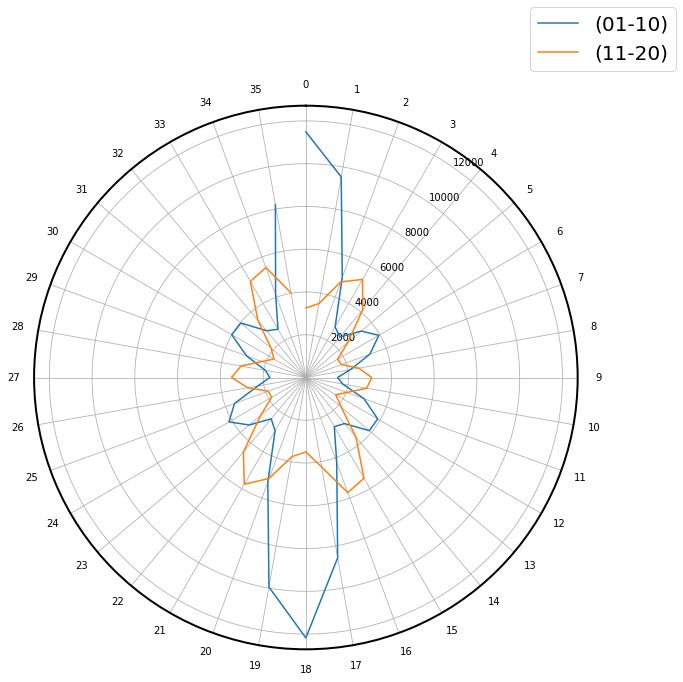

In [13]:
##Test plot
##Data looks like this: m_strains2[peak][step][cake-strain]

matrix_peak_names = ['(01-10)', '(11-20)', '(02-20)', '(01-13)']

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, m_amp2[0][57], label = matrix_peak_names[0])
ax.plot(pp_range_rad, m_amp2[1][57], label = matrix_peak_names[1])
#ax.plot(pp_range_rad, m_fwhm2[2][40], label = matrix_peak_names[2])
#ax.plot(pp_range_rad, m_strains2[3][40], label = matrix_peak_names[3])
ax.legend(loc = 0, bbox_to_anchor = (1.2, 1.2))
ax.set_rlabel_position(35)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=-0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
#ax.set_rmax(0.06)
#ax.set_rmin(0)
ax.set_xticklabels(cake_nums)
#ax.set_rorigin(-2000)
plt.show()

In [ ]:
##generate gif of line plot for matrx peaks

import imageio
from matplotlib.pyplot import close

gif_dir = '\gif'
matrix_plots = '\matrix'
matrix_peak_names = ['(01-10)', '(11-20)', '(02-20)', '(01-13)']

images = []

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

identifyer = ['o', '+', '*', '-']

fig, ax = plt.subplots(figsize = (10, 10))

for step in range(len(m_strains2[0])): #58
    for peak in range(len(m_strains2[0:2])):     
        ax = plt.subplot(111, projection='polar')
        ax.plot(pp_range_rad, m_amp2[peak][step][:], label = matrix_peak_names[peak])
        ax.legend(loc=(1,1))
        title = 'S2_Step_' + str(step) + '_Matrix_Area'
        ax.set_title(title, va='bottom')
        ax.set_rlabel_position(45)  # Move radial labels away from plotted line
        ax.set_rlim(0, 12500)
        ax.set_rorigin(-2000)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0.0)
        ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
        ax.set_xticklabels(cake_nums)
        
    plot_name= str(out_dir+gif_dir+'\\'+str(step))
    #print(plot_name)

    fig.savefig(plot_name, bbox_inches='tight')
    fig.clf()

    images.append(imageio.imread(plot_name + '.png'))

close('all')
    
imageio.mimsave(out_dir + matrix_plots + '\polar_line_matrix_area_01-10_11-20.gif', images)

##DELETE GENERATED PNG FILES
for file in os.scandir(out_dir+gif_dir):
    if file.name.endswith(".png"):
        os.unlink(file.path)

-

- For Hydride Peaks

-

In [14]:
##data is now stored in two lists
##Peak name and cake are in 'list_blah_peaks'
##the location (in two theta) are in 'list_blah_peak_centres'

##objective: re-arrange data into format: [peak][cake][step]


pk_names = ['111', '220', '311']

peak_cake_pos = []
peak_centres = []
z_fwhm = []
z_amp = []

for i in pk_names:
    new_list = []
    new_list2 = []
    tmp_fwhm = []
    tmp_amp = []
    for j,k,l,m in zip(list_ZrH_peaks, list_ZrH_peak_centres, list_ZrH_peak_fwhm, list_ZrH_peak_amplitude):
        if i in j:
            new_list.append(j.split('_')[0]) # append name 'cake_peak'
            new_list2.append(k) #append list of centres
            tmp_fwhm.append(l)
            tmp_amp.append(m)
    peak_cake_pos.append(new_list) #list of 'cake value' for peaks
    peak_centres.append(new_list2) #list of data matching shape of list: peak_cake_pos
    z_fwhm.append(tmp_fwhm)
    z_amp.append(z_amp)
    
print(peak_cake_pos)

#q[peak][cake][step]
#print(len(peak_centres), len(peak_centres[2]), len(peak_centres[2][0]))
#for i in range(8):
#   print(peak_centres[2][i][20])

[['0', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '3', '4', '5', '6', '7', '8', '9'], ['0', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '3', '4', '5', '6', '7', '8', '9'], ['0', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '3', '4', '5', '6', '7', '8', '9']]


In [15]:
#Convert peak centres to lattice strain
#print(len(z_cakes_list), len(z_peaks_list), z_cakes_list, z_peaks_list)

z_strains_list = []

for i in list_ZrH_peak_centres:
    L_strain = calc_strain_singlepoint(i)*1e6
    L_strain = list(L_strain)
    z_strains_list.append(L_strain)
        
#Seperate into the peaks

#list[first peak, second peak, third... ]

z_strains_by_peak = [[],[],[],[]]
z_cakes_by_peak = [[],[],[],[]]
z_peaks_by_peak = [[],[],[],[]]
z_fwhm_by_peak = [[],[],[],[]]
z_amp_by_peak = [[],[],[],[]]
z_cntr_by_peak = [[],[],[],[]]

for i in range(len(z_strains_by_peak)):
    for j in range(0,36):
        j = []
        z_strains_by_peak[i].append(j)
        z_cakes_by_peak[i].append(j)
        z_peaks_by_peak[i].append(j)
        z_fwhm_by_peak[i].append(j)
        z_amp_by_peak[i].append(j)
        z_cntr_by_peak[i].append(j)

for i,j,k,l,m,n in zip(z_peaks_list, z_cakes_list, z_strains_list, list_ZrH_peak_fwhm, list_ZrH_peak_amplitude, list_ZrH_peak_centres):
    index = int(j)    
    if i == '(111)':
        z_strains_by_peak[0][index] = k
        z_cakes_by_peak[0][index] = j
        z_peaks_by_peak[0][index] = i
        z_fwhm_by_peak[0][index] = l
        z_amp_by_peak[0][index] = m
        z_cntr_by_peak[0][index] = n
    
    if i == '(220)':
        z_strains_by_peak[1][index] = k
        z_cakes_by_peak[1][index] = j
        z_peaks_by_peak[1][index] = i
        z_fwhm_by_peak[1][index] = l
        z_amp_by_peak[1][index] = m
        z_cntr_by_peak[1][index] = n
        
    if i == '(311)':
        z_strains_by_peak[2][index] = k
        z_cakes_by_peak[2][index] = j
        z_peaks_by_peak[2][index] = i
        z_fwhm_by_peak[2][index] = l
        z_amp_by_peak[2][index] = m
        z_cntr_by_peak[2][index] = n
        
#print('cake order', len(m_cakes_by_peak), len(m_cakes_by_peak[0]), '\n', m_cakes_by_peak[0], '\n')

##Pad empty lists

for i, j in enumerate(z_strains_by_peak):
    for k, l in enumerate(j):
        if l == []:
            z_strains_by_peak[i][k] = np.zeros(58)
            
for i, j in enumerate(z_cakes_by_peak):
    for k, l in enumerate(j):
        if l == []:
            z_cakes_by_peak[i][k] = k
            
for i, j in enumerate(z_fwhm_by_peak):
    for k, l in enumerate(j):
        if l == []:
            z_fwhm_by_peak[i][k] = np.zeros(58)
            
for i, j in enumerate(z_amp_by_peak):
    for k, l in enumerate(j):
        if l == []:
            z_amp_by_peak[i][k] = np.zeros(58)

for i, j in enumerate(z_cntr_by_peak):
    for k, l in enumerate(j):
        if l == []:
            z_cntr_by_peak[i][k] = np.zeros(58)
            
## Data now stored in 4 peak lists in order
        


In [16]:
##re-arrange data into format: [peak][step][cake-strain]

z_strains2 = []
z_fwhm2 = []
z_amp2 = []
z_cntr2 = []
        
for peak in range(len(z_strains_by_peak)): #generate 4 lists
    tmp1_strain = []
    tmp1_fwhm = []
    tmp1_amp = []
    tmp1_cntr = []
    
    for i in range(len(z_strains_by_peak[peak][0])): # generate 58 lists
        tmp2_strain = []
        tmp2_fwhm = []
        tmp2_amp = []
        tmp2_cntr = []
        tmp1_strain.append(tmp2_strain) #append 58 lists to tmp1
        tmp1_fwhm.append(tmp2_fwhm)
        tmp1_amp.append(tmp2_amp)
        tmp1_cntr.append(tmp2_cntr)
    
        for cake in range(len(z_strains_by_peak[peak])): # generate 36 lists
            strain = z_strains_by_peak[peak][cake][i]
            tmp1_strain[i].append(strain) #append 36 lists to tmp1[i]
            
            fwhm = z_fwhm_by_peak[peak][cake][i]
            tmp1_fwhm[i].append(fwhm)
            
            amp = z_amp_by_peak[peak][cake][i]
            tmp1_amp[i].append(amp)
            
            cntr = z_cntr_by_peak[peak][cake][i]
            tmp1_cntr[i].append(cntr)
        
    z_strains2.append(tmp1_strain)
    z_fwhm2.append(tmp1_fwhm)
    z_amp2.append(tmp1_amp)
    z_cntr2.append(tmp1_cntr)
    
print(len(z_strains2), len(z_fwhm2), len(z_amp2), len(z_cntr2))
print(len(z_strains2[0]), len(z_fwhm2[0]), len(z_amp2[0]), len(z_cntr2[0]))
print(len(z_strains2[2][0]), len(z_fwhm2[0][0]), len(z_amp2[0][0]), len(z_cntr2[0][0]))

4 4 4 4
58 58 58 58
36 36 36 36


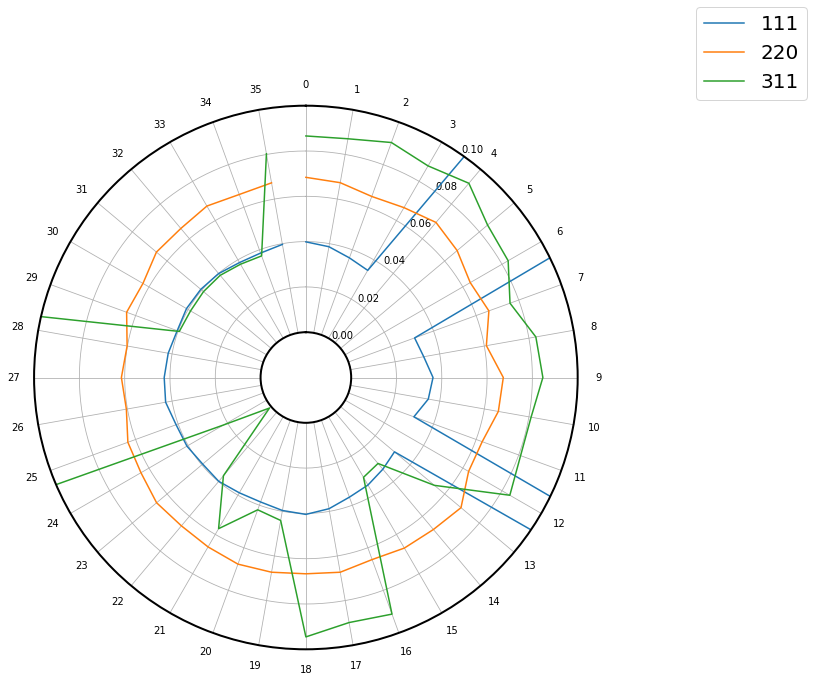

In [17]:
##Test plot
##Data looks like this: m_strains2[peak][step][cake-strain]

zrh_pk_names = ['111', '220', '311']

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, z_fwhm2[0][0], label = zrh_pk_names[0])
ax.plot(pp_range_rad, z_fwhm2[1][0], label = zrh_pk_names[1])
ax.plot(pp_range_rad, z_fwhm2[2][0], label = zrh_pk_names[2])
#ax.plot(pp_range_rad, z_fwhm2[3][0], label = zrh_pk_names[3])
ax.legend(loc = 0, bbox_to_anchor = (1.2, 1.2))
ax.set_rlabel_position(35)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=-0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rmax(0.1)
ax.set_rmin(0)
ax.set_xticklabels(cake_nums)
ax.set_rorigin(-0.02)
plt.show()

In [ ]:
##generate gif of line plot for matrx peaks

import imageio
from matplotlib.pyplot import close

gif_dir = '\gif'
hydride_plots = '\zrh'

images = []

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

identifyer = ['o', '+', '*', '-']

fig, ax = plt.subplots(figsize = (10, 10))

for step in range(len(z_strains2[0])): #58
    for peak in range(len(z_strains2[0:2])):     
        ax = plt.subplot(111, projection='polar')
        ax.plot(pp_range_rad, z_fwhm2[peak][step][:], label = zrh_pk_names[peak])
        ax.legend(loc=(1,1))
        title = 'S2_Step_' + str(step) + '_Hydride_fwhm'
        ax.set_title(title, va='bottom')
        ax.set_rlabel_position(45)  # Move radial labels away from plotted line
        ax.set_rlim(0, 0.1)
        #ax.set_rorigin(-200)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0.0)
        ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
        ax.set_xticklabels(cake_nums)
        
    plot_name= str(out_dir+gif_dir+'\\'+str(step))
    #print(plot_name)

    fig.savefig(plot_name, bbox_inches='tight')
    fig.clf()

    images.append(imageio.imread(plot_name + '.png'))

close('all')
    
imageio.mimsave(out_dir + hydride_plots + '\polar_line_hydride_fwhm_111_220.gif', images)

##DELETE GENERATED PNG FILES
for file in os.scandir(out_dir+gif_dir):
    if file.name.endswith(".png"):
        os.unlink(file.path)

Single polar rose plot

In [ ]:
##log scale?
##shift gridlines by 5 deg?

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

width = np.pi/180*(10/3)
half_cake = np.pi/180*(10/2)

rmax = 30000
rmin=-5000


#radial_lines = np.full(36, rmax).tolist()

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.bar(pp_range_rad, strains_list2[0][5][:], width, label = '(111)', edgecolor='grey')
ax.bar(pp_range_rad+width, strains_list2[1][5][:], width, label = '(220)', edgecolor='grey')
ax.bar(pp_range_rad-width, strains_list2[2][5][:], width, label = '(311)', edgecolor='grey')
ax.legend(loc = 0, bbox_to_anchor = (1.1, 1.1))
ax.set_rlabel_position(65)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rorigin(-20000)
ax.set_rmax(rmax)
ax.set_rmin(rmin)
ax.set_xticklabels(cake_nums)
#ax.set_yticklabels(rotation=90)
ax.set_theta_zero_location('N', offset=0)
#ax.axes.get_xaxis().set_visible(False)
plt.show()
fig.savefig(out_dir)

In [ ]:
### all steps as subplots

num_plots = len(strains_list2[0])
fig, ax = plt.subplots(num_plots, figsize=(10, 580), subplot_kw=dict(projection='polar'))

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

identifyer = ['o', '+', '*']
width = np.pi/180*(10/3)
#colours = plt.cm.viridis(radii / 10.)
position = [width*-1, 0, width]

for peak, pos in zip(range(len(strains_list2)), position): #3
    for step in range(len(strains_list2[peak])): #58
        ax[step].bar(pp_range_rad+pos, strains_list2[peak][step][:], width, label=pk_names[peak])
        ax[step].legend(loc=(1,1))
        title = 'S2_Step_' + str(step) + '_Strain'
        ax[step].set_title(title, va='bottom')
        ax[step].set_rlabel_position(45)  # Move radial labels away from plotted line
        ax[step].set_rlim(-5000, 30000)
        ax[step].set_theta_direction(-1)
        ax[step].set_theta_zero_location('N', offset=0.0)
        ax[step].set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
        ax[step].set_xticklabels(cake_nums)

In [ ]:
##Generate gif of Polar plots

import imageio
from matplotlib.pyplot import close

gif_dir = '\gif'

images = []

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

identifyer = ['o', '+', '*']
width = np.pi/180*(10/3)
#colours = plt.cm.viridis(radii / 10.)
position = [width*-1, 0, width]

fig, ax = plt.subplots(figsize = (10, 10))

for step in range(len(strains_list2[0])): #58
    for peak, pos in zip(range(len(strains_list2[0:2])), position): #3    
        ax = plt.subplot(111, projection='polar')
        ax.bar(pp_range_rad+pos, strains_list2[peak][step][:], width, label=pk_names[peak], edgecolor='grey')
        ax.legend(loc=(0.9, 0.9))
        title = 'S2_Step_' + str(step) + '_Strain'
        ax.set_title(title, va='bottom')
        ax.set_rlabel_position(45)  # Move radial labels away from plotted line
        ax.set_rlim(-5000, 30000)
        ax.set_rorigin(-20000)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0.0)
        ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
        ax.set_xticklabels(cake_nums)
        
    plot_name= str(out_dir+gif_dir+'\\'+str(step))
    #print(plot_name)

    fig.savefig(plot_name, bbox_inches='tight')
    fig.clf()

    images.append(imageio.imread(plot_name + '.png'))

close('all')
    
imageio.mimsave(out_dir + '\polar_strain_doughnut_111_220.gif', images)

##DELETE GENERATED PNG FILES
for file in os.scandir(out_dir+gif_dir):
    if file.name.endswith(".png"):
        os.unlink(file.path)

#Calculate difference accross opposits

-

-

-

-

In [ ]:
###strains_list2[peak][step][cake-strain]

diffs = [[],[],[]]

for i in range(len(strains_list2[0][56])): #'111''56' = 36
    cake = i
    opp = i+36/2
    if opp >= 36:
        opp = -18+i
    opp = int(opp)
    
    for j in range(3):
        if strains_list2[j][56][cake] == 0 or strains_list2[j][56][opp] == 0: 
            diff = 0
            diffs[j].append(diff)

        else:
            diff = strains_list2[j][56][cake]-strains_list2[j][56][opp]
            diffs[j].append(diff)
        
for k, peak in enumerate(pk_names):
    print(peak)
    for j in range(36):
        opp = j+int(36/2)
        if opp >= 36:
            opp = -18+j
        print(j, '\t', int(strains_list2[k][56][j]), '\t', opp, '\t', int(strains_list2[k][56][opp]),'\t', diffs[k][j])
    print('\n')


In [ ]:
###strains_list2[peak][step][cake-strain]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, medfilt(diffs[0], 3), label = '(111)')
ax.plot(pp_range_rad, medfilt(diffs[1], 3), label = '(220)')
#ax.plot(pp_range_rad, diffs[2], label = '(311)')
ax.legend(loc = 0, bbox_to_anchor = (1.1, 1.1))
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rorigin(-2000)
#ax.set_rmax(30000)
#ax.set_rmin(-5000)
ax.set_xticklabels(cake_nums)
title = 'S2_Difference in opposing hydride strain_S56 \n\n *Difference, in microstrain on radial axis \n *Cake position on theta axis'
ax.set_title(title, va='bottom')

gridlines = ax.yaxis.get_gridlines()
gridlines[3].set_color("grey")
gridlines[3].set_linewidth(2.5)

plt.show()

plot_name= str(out_dir+'\\'+'difference in opposing strains_hydride_111_220')
#print(plot_name)
fig.savefig(plot_name, bbox_inches='tight')

In [ ]:
###strains_list2[peak][step][cake-strain]

pcnt_diffs = [[],[],[]] # strain c0 - strain c18/strain c18

for i in range(len(strains_list2[0][56])): #'111''56' = 36
    cake = i
    opp = i+36/2
    if opp >= 36:
        opp = -18+i
    opp = int(opp)
    
    for j in range(3):
        if strains_list2[j][56][cake] == 0 or strains_list2[j][56][opp] == 0: 
            diff = 0
            pcnt_diffs[j].append(diff)

        else:
            diff = 100*(strains_list2[j][56][cake]-strains_list2[j][56][opp])/strains_list2[j][56][opp]
            pcnt_diffs[j].append(diff)
        
for k, peak in enumerate(pk_names):
    print(peak)
    for j in range(36):
        opp = j+int(36/2)
        if opp >= 36:
            opp = -18+j
        print(j, '\t', int(strains_list2[k][56][j]), '\t', opp, '\t', int(strains_list2[k][56][opp]),'\t', pcnt_diffs[k][j])
    print('\n')


In [ ]:
###strains_list2[peak][step][cake-strain]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, medfilt(pcnt_diffs[0], 3), label = '(111)')
ax.plot(pp_range_rad, medfilt(pcnt_diffs[1], 3), label = '(220)')
#ax.plot(pp_range_rad, pcnt_diffs[2], label = '(311)')
ax.legend(loc = 0, bbox_to_anchor = (1.1, 1.1))
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rorigin(-100)
#ax.set_rmax(30000)
#ax.set_rmin(-5000)
ax.set_xticklabels(cake_nums)

gridlines = ax.yaxis.get_gridlines()
gridlines[4].set_color("grey")
gridlines[4].set_linewidth(2.5)

plt.show()

plot_name= str(out_dir+'\\'+'difference')
#print(plot_name)

fig.savefig(plot_name, bbox_inches='tight')

Williamson Hall Plots
x

x

x

x

In [18]:
def Contrast_Factor(C_h00, q, H_sqd):
    C = C_h00*(1-q*H_sqd)
    return C

def H_sqd(h,k,l):
    H_squared = (h**2*k**2+h**2*l**2+k**2*l**2)/(h**2+k**2+l**2)**2
    return H_squared

def K(pk_cntr, wavelength):
    Ka = (2*sin(0.5*pk_cntr*pi/180))/wavelength
    return Ka

def delta_K(pk_cntr, FWHM, wavelength):
    delta_Ka = (FWHM*cos(0.5*pk_cntr*pi/180))/wavelength
    return delta_Ka

In [129]:
##Let's set up some constants 
C_zrh_h00 = 3.2
C_mx_h00 = 3.2
q_zrh = 2.5
q_mx = 0.5
wavelength = 0.0141565

In [130]:
## And now calculate some parameters

#matrix_peak_names = ['(01-10)', '(11-20)', '(02-20)', '(01-13)']
#zrh_pk_names = ['111', '220', '311']

Hsqd_zrh111 = H_sqd(1,1,1)
Hsqd_zrh200 = H_sqd(2,0,0)
Hsqd_zrh220 = H_sqd(2,2,0)
Hsqd_zrh311 = H_sqd(3,1,1)
Hsqd_zrh = [Hsqd_zrh111, Hsqd_zrh220, Hsqd_zrh311]

Hsqd_mx100 = H_sqd(1,0,0)
Hsqd_mx110 = H_sqd(1,1,0)
Hsqd_mx200 = H_sqd(2,0,0)
Hsqd_mx103 = H_sqd(1,0,3)
Hsqd_mx = [Hsqd_mx100, Hsqd_mx110, Hsqd_mx200, Hsqd_mx103]

C_zrh111 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh111)
C_zrh200 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh200)
C_zrh220 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh220)
C_zrh311 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh311)
C_zrh = [C_zrh111, C_zrh220, C_zrh311]

C_mx100 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx100)
C_mx110 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx110)
C_mx200 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx200)
C_mx103 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx103)
C_mx = [C_mx100, C_mx110, C_mx200, C_mx103]

K_zrh111 = K(z_cntr2[0][0][0], wavelength)
#K_zrh200 = K(z_cntr2[x][0][0], wavelength)
K_zrh220 = K(z_cntr2[1][0][0], wavelength)
K_zrh311 = K(z_cntr2[2][0][0], wavelength)
K_zrh = [K_zrh111, K_zrh220, K_zrh311]

K_mx100 = K(m_cntr2[0][0][0], wavelength)
K_mx110 = K(m_cntr2[1][0][0], wavelength)
K_mx200 = K(m_cntr2[2][0][0], wavelength)
K_mx103 = K(m_cntr2[3][0][0], wavelength)
K_mx = [K_mx100, K_mx110, K_mx200, K_mx103]

dK_zrh111 = delta_K(z_cntr2[0][0][0], z_fwhm2[0][0][0], wavelength)
#dK_zrh200 = delta_K(z_cntr2[x][0][0], z_fwhm2[x][0][0], wavelength)
dK_zrh220 = delta_K(z_cntr2[1][0][0], z_fwhm2[1][0][0], wavelength)
dK_zrh311 = delta_K(z_cntr2[2][0][0], z_fwhm2[2][0][0], wavelength)
dK_zrh = [dK_zrh111, dK_zrh220, K_zrh311]

dK_mx100 = delta_K(m_cntr2[0][0][0], m_fwhm2[0][0][0], wavelength)
dK_mx110 = delta_K(m_cntr2[1][0][0], m_fwhm2[1][0][0], wavelength)
dK_mx200 = delta_K(m_cntr2[2][0][0], m_fwhm2[2][0][0], wavelength)
dK_mx103 = delta_K(m_cntr2[3][0][0], m_fwhm2[3][0][0], wavelength)
dK_mx = [dK_mx100, dK_mx110, dK_mx200, dK_mx103]

ZrH_FWHM = [z_fwhm2[0][0][0], z_fwhm2[1][0][0], z_fwhm2[2][0][0]]
mx_FWHM = [m_fwhm2[0][0][0], m_fwhm2[1][0][0], m_fwhm2[2][0][0], m_fwhm2[3][0][0]]

'''#Quick check
print('Hsqd_zrh','\t', 'C_zrh','\t', 'K_zrh','\t', 'dK_zrh','\t', 'ZrH_FWHM')
for i in zip(Hsqd_zrh, C_zrh, K_zrh, dK_zrh, ZrH_FWHM):
    print(i, '\n')'''

##now lets plot k_sqrt(C) vs delta_K 

##calc K*sqrt(C)
K_rootC_zrh = []
for i, j in zip(K_zrh, C_zrh):
    rt_j = math.sqrt(j)
    K_sqrtC_zrh = i*rt_j
    K_rootC_zrh.append(K_sqrtC_zrh)

K_rootC_mx = []
for i, j in zip(K_mx, C_mx):
    rt_j = math.sqrt(j)
    K_sqrtC_mx = i*rt_j
    K_rootC_mx.append(K_sqrtC_mx)

Text(0.5, 0, 'K$\\sqrt{2}$')

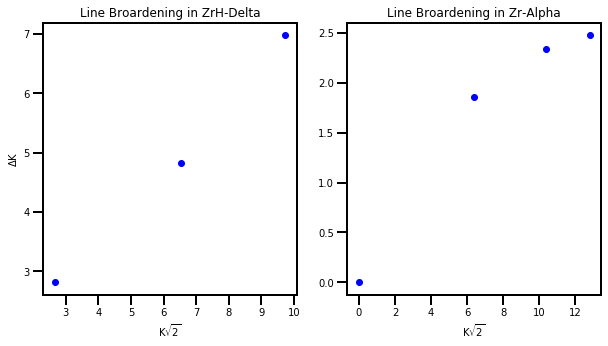

In [131]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10, 5))

ax0.plot(K_rootC_zrh, dK_zrh, 'bo')
title0 = ('Line Broardening in ZrH-Delta')
ax0.set_title(title0)
ax0.set_xlabel(r'K$\sqrt{2}$')
ax0.set_ylabel(r'$\Delta$K')

ax1.plot(K_rootC_mx, dK_mx, 'bo')
title1 = ('Line Broardening in Zr-Alpha')
ax1.set_title(title1)
ax1.set_xlabel(r'K$\sqrt{2}$')

In [157]:
## now to do this over the full strain range
# H_sqrd & C are constant BUT K and dK will vary

K_zrh = []
dK_zrh = []

for i in range(3):
    peak = int(i)
    K_zrh_tmp = []
    dK_zrh_tmp = []
    K_zrh.append(K_zrh_tmp)
    dK_zrh.append(dK_zrh_tmp)
    
    for j in range(58):
        step = int(j)
        pk_cntr_zrh = z_cntr2[peak][step][0]
        pk_fwhm_zrh = z_fwhm2[peak][step][0]
        k_zirk_h = K(pk_cntr_zrh, wavelength)
        dk_zirk_h = delta_K(pk_cntr_zrh, pk_fwhm_zrh, wavelength)
       
        K_zrh[peak].append(k_zirk_h)       
        dK_zrh[peak].append(dk_zirk_h)
        
K_mx = []
dK_mx = []

for i in range(4):
    peak = int(i)
    K_mx_tmp = []
    dK_mx_tmp = []
    K_mx.append(K_mx_tmp)
    dK_mx.append(dK_mx_tmp)
    
    for j in range(58):
        step = int(j)
        pk_cntr_mx = m_cntr2[peak][step][0]
        pk_fwhm_mx = m_fwhm2[peak][step][0]
        k_mx = K(pk_cntr_mx, wavelength)
        dk_mx = delta_K(pk_cntr_mx, pk_fwhm_mx, wavelength)
        
        K_mx[peak].append(k_mx)
        dK_mx[peak].append(dk_mx)

In [158]:
##calc K*sqrt(C)
K_rootC_zrh = []
K_rootC_mx = []

for h, i, j in zip(range(3), K_zrh, C_zrh):
    peak = int(h)
    tmp = []
    K_rootC_zrh.append(tmp)
    for k in i:
        rt_j_zrh = math.sqrt(j)
        K_sqrtC_zrh = k*rt_j_zrh
        K_rootC_zrh[h].append(K_sqrtC_zrh)
        
for h, i, j in zip(range(4), K_mx, C_mx):
    peak = int(h)
    tmp = []
    K_rootC_mx.append(tmp)
    for k in i:
        rt_j_mx = math.sqrt(j)
        K_sqrtC_mx = k*rt_j_mx
        K_rootC_mx[h].append(K_sqrtC_mx)

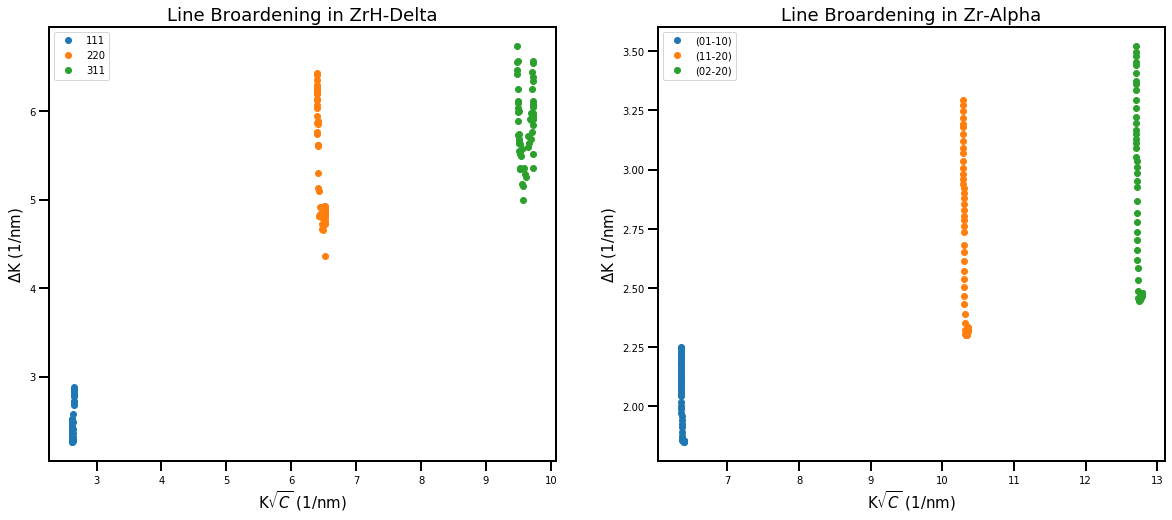

In [238]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20, 8))

for i, j in enumerate(zrh_pk_names):
    ax0.plot(K_rootC_zrh[i], dK_zrh[i], 'o', label=j)
    ax0.legend(loc = 2,  fontsize=10)
    title0 = ('Line Broardening in ZrH-Delta')
    ax0.set_title(title0, fontsize=18)
    ax0.set_xlabel(r'K$\sqrt{C}$ (1/nm)', fontsize=15)
    ax0.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

for i, j in enumerate(matrix_peak_names[:-1]):
    ax1.plot(K_rootC_mx[i], dK_mx[i], 'o', label=j)
    ax1.legend(loc = 2, fontsize=10)
    title1 = ('Line Broardening in Zr-Alpha')
    ax1.set_title(title1, fontsize=18)
    ax1.set_xlabel(r'K$\sqrt{C}$ (1/nm)', fontsize=15)
    ax1.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)
    
fig.savefig(r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\S2_Out_plots\W-H Plots\W-H Plots')

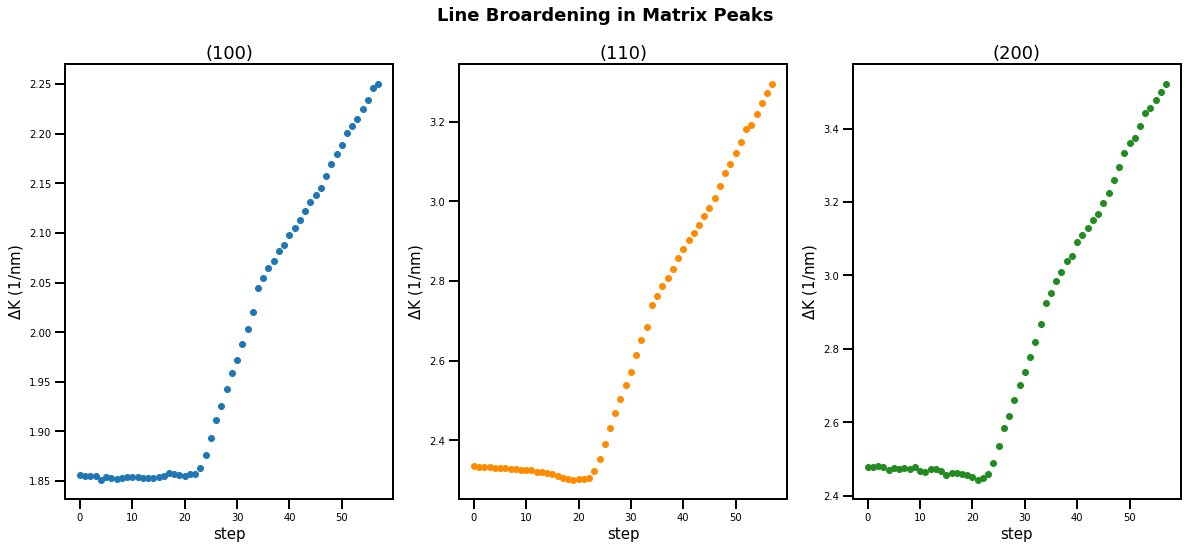

In [239]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(20, 8))

fig.suptitle('Line Broardening in Matrix Peaks', fontsize=18, fontweight='bold');

ax0.plot(list(range(58)), dK_mx[0], 'o', label='100')
#ax0.legend(loc = 2,  fontsize=10)
title0 = ('(100)')
ax0.set_title(title0, fontsize=18)
ax0.set_xlabel('step', fontsize=15)
ax0.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

ax1.plot(list(range(58)), dK_mx[1], 'o', color='darkorange', label='110')
#ax1.legend(loc = 2,  fontsize=10)
title1 = ('(110)')
ax1.set_title(title1, fontsize=18)
ax1.set_xlabel('step', fontsize=15)
ax1.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

ax2.plot(list(range(58)), dK_mx[2], 'o',color='forestgreen', label='200')
#ax2.legend(loc = 2,  fontsize=10)
title2 = ('(200)')
ax2.set_title(title2, fontsize=18)
ax2.set_xlabel('step', fontsize=15)
ax2.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

fig.savefig(r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\S2_Out_plots\W-H Plots\FWHM_Matrix_vs_Steps')

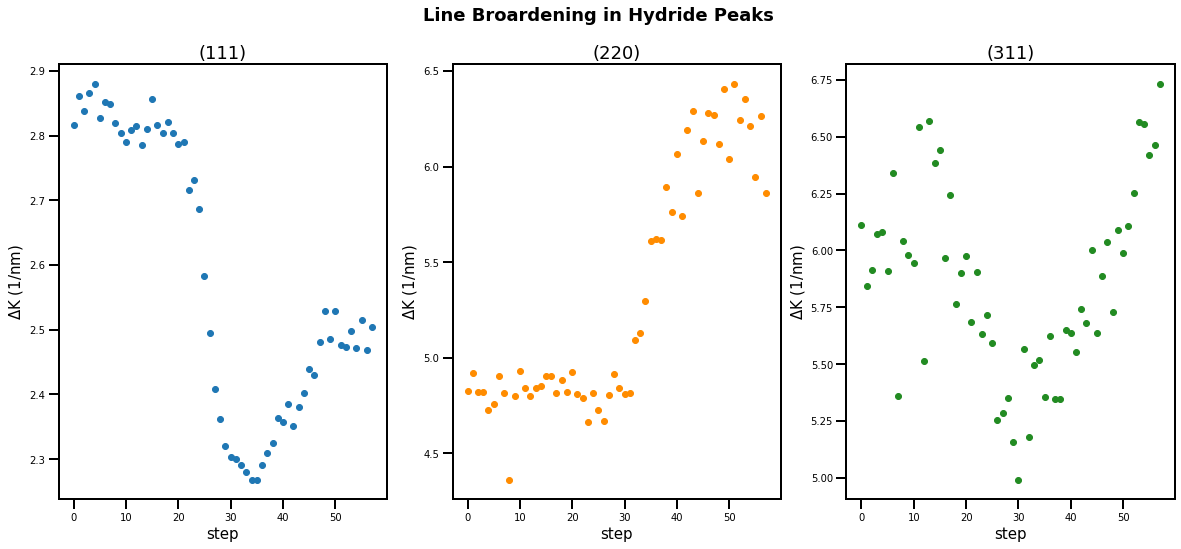

In [240]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(20, 8))

fig.suptitle('Line Broardening in Hydride Peaks', fontsize=18, fontweight='bold');

ax0.plot(list(range(58)), dK_zrh[0], 'o', label='111')
#ax0.legend(loc = 2,  fontsize=10)
title0 = ('(111)')
ax0.set_title(title0, fontsize=18)
ax0.set_xlabel('step', fontsize=15)
ax0.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

ax1.plot(list(range(58)), dK_zrh[1], 'o', color='darkorange', label='220')
#ax1.legend(loc = 2,  fontsize=10)
title1 = ('(220)')
ax1.set_title(title1, fontsize=18)
ax1.set_xlabel('step', fontsize=15)
ax1.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

ax2.plot(list(range(58)), dK_zrh[2], 'o',color='forestgreen', label='311')
#ax2.legend(loc = 2,  fontsize=10)
title2 = ('(311)')
ax2.set_title(title2, fontsize=18)
ax2.set_xlabel('step', fontsize=15)
ax2.set_ylabel(r'$\Delta$K (1/nm)', fontsize=15)

fig.savefig(r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\S2_Out_plots\W-H Plots\FWHM_Hydride_vs_Steps')